In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.stats import kurtosis, skew, entropy
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import skimage
from skimage import io, exposure, morphology, filters, color, segmentation, feature, measure, img_as_float, img_as_ubyte, transform
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle

In [ ]:
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 4.5 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [ ]:
#Training set organization
train_bcc= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [ ]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [ ]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

2713
2713
2632
498
678
94


In [ ]:
#Training set DataFrame construction
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [ ]:
#Validation set DataFrame construction
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [ ]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [ ]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [ ]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [ ]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [ ]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [ ]:
def texture_feature_extractor(images_routes):
  mean_contrast=[]
  mean_dissimilarity=[]
  mean_homogeneity=[]
  mean_energy=[]
  mean_correlation=[]
  std_contrast=[]
  std_dissimilarity=[]
  std_homogeneity=[]
  std_energy=[]
  std_correlation=[]
  counter=1
  for i in images_routes:

    img= cv2.imread(i)
    img_bw= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    glcm_matrix= feature.graycomatrix(img_bw, distances=[1,2,3], angles=[0,np.pi/4,np.pi/2, 3/2*np.pi], levels=256)
    glcm_mean_contrast= np.mean(feature.graycoprops(glcm_matrix, 'contrast'))
    glcm_mean_dissimilarity= np.mean(feature.graycoprops(glcm_matrix, 'dissimilarity'))
    glcm_mean_homogeneity = np.mean(feature.graycoprops(glcm_matrix, 'homogeneity'))
    glcm_mean_energy = np.mean(feature.graycoprops(glcm_matrix,'energy'))
    glcm_mean_correlation = np.mean(feature.graycoprops(glcm_matrix,'correlation'))
    glcm_std_contrast= np.std(feature.graycoprops(glcm_matrix, 'contrast'))
    glcm_std_dissimilarity= np.std(feature.graycoprops(glcm_matrix, 'dissimilarity'))
    glcm_std_homogeneity = np.std(feature.graycoprops(glcm_matrix, 'homogeneity'))
    glcm_std_energy = np.std(feature.graycoprops(glcm_matrix,'energy'))
    glcm_std_correlation = np.std(feature.graycoprops(glcm_matrix,'correlation'))
    mean_contrast.append(glcm_mean_contrast)
    mean_dissimilarity.append(glcm_mean_dissimilarity)
    mean_homogeneity.append(glcm_mean_homogeneity)
    mean_energy.append(glcm_mean_energy)
    mean_correlation.append(glcm_mean_correlation)
    std_contrast.append(glcm_std_contrast)
    std_dissimilarity.append(glcm_std_dissimilarity)
    std_homogeneity.append(glcm_std_homogeneity)
    std_energy.append(glcm_std_energy)
    std_correlation.append(glcm_std_correlation)
  texture_features={'glcm_mean_contrast': mean_contrast, 'glcm_mean_dissimilarity': mean_dissimilarity,
                    'glcm_mean_homogeneity': mean_homogeneity, 'glcm_mean_energy': mean_energy,
                    'glcm_mean_correlation': mean_correlation, 'glcm_std_contrast': std_contrast,
                    'glcm_std_dissimilarity': std_dissimilarity, 'glcm_std_homogeneity': std_homogeneity,
                    'glcm_std_energy':std_energy, 'glcm_std_correlation': std_correlation}
  result = pd.DataFrame.from_dict(texture_features)

  return result

In [ ]:
X_train_features = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Train_TextureFeatures291022.csv')
X_test_features = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Test_TextureFeatures291022.csv')

In [ ]:
# X_train_features= texture_feature_extractor(X_train)
# X_test_features= texture_feature_extractor(X_test)
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

In [ ]:
# X_train_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Train_TextureFeatures291022.csv',index=False)
# X_test_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Test_TextureFeatures291022.csv',index=False)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       678
           1       0.61      0.64      0.63       498
           2       0.14      0.19      0.16        94

    accuracy                           0.63      1270
   macro avg       0.50      0.51      0.50      1270
weighted avg       0.65      0.63      0.64      1270

0.5073027943065805
Kappa Score :
0.3565383411036115


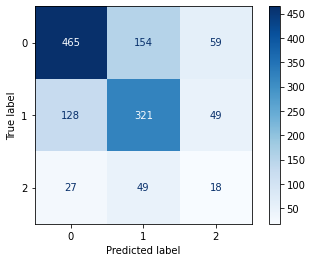

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model1, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/GLCMSVM_model.sav', 'wb'))

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       678
           1       0.58      0.61      0.59       498
           2       0.11      0.18      0.13        94

    accuracy                           0.57      1270
   macro avg       0.46      0.46      0.46      1270
weighted avg       0.61      0.57      0.59      1270

0.4641765455092195
Kappa Score :
0.2690775783932835


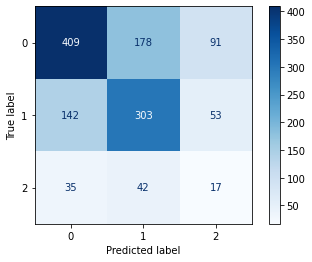

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       678
           1       0.62      0.65      0.64       498
           2       0.14      0.20      0.17        94

    accuracy                           0.63      1270
   macro avg       0.50      0.51      0.50      1270
weighted avg       0.65      0.63      0.64      1270

0.5102210133447869
Kappa Score :
0.3569780603416497


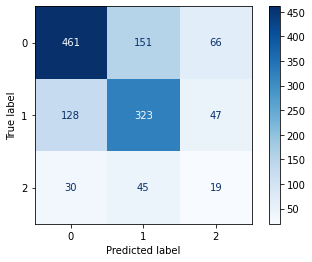

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model3, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/GLCMGBoost_model.sav', 'wb'))

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       678
           1       0.65      0.70      0.68       498
           2       0.24      0.26      0.25        94

    accuracy                           0.68      1270
   macro avg       0.56      0.56      0.56      1270
weighted avg       0.69      0.68      0.69      1270

0.5615786437030366
Kappa Score :
0.435564270306276


In [ ]:
pickle.dump(model4, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/GLCMRF_model.sav', 'wb'))

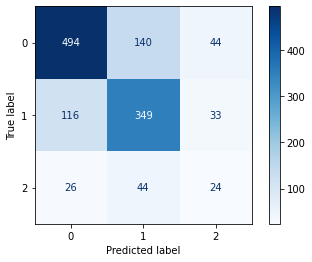

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70       678
           1       0.61      0.57      0.59       498
           2       0.11      0.18      0.13        94

    accuracy                           0.60      1270
   macro avg       0.48      0.48      0.47      1270
weighted avg       0.63      0.60      0.61      1270

0.4761773510914303
Kappa Score :
0.3037460686743354


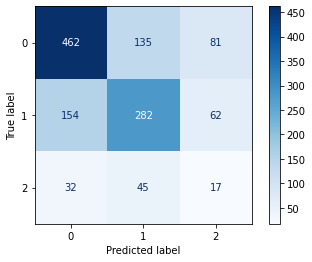

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       678
           1       0.58      0.59      0.58       498
           2       0.17      0.33      0.22        94

    accuracy                           0.59      1270
   macro avg       0.49      0.51      0.49      1270
weighted avg       0.63      0.59      0.60      1270

0.5136975442093485
Kappa Score :
0.3005990541250656


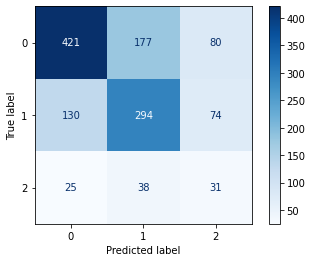

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.75      0.67      0.70       678
           1       0.62      0.66      0.64       498
           2       0.14      0.20      0.17        94

    accuracy                           0.63      1270
   macro avg       0.50      0.51      0.50      1270
weighted avg       0.65      0.63      0.64      1270

0.5079819686705146
Kappa Score :
0.3516239891892359


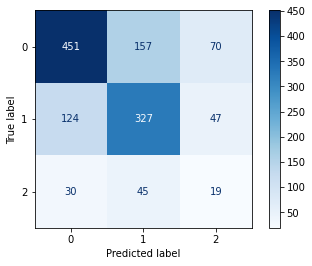

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model7, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/GLCMXGBoost_model.sav', 'wb'))

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.72      0.48      0.58       678
           1       0.51      0.67      0.58       498
           2       0.12      0.21      0.16        94

    accuracy                           0.53      1270
   macro avg       0.45      0.45      0.44      1270
weighted avg       0.59      0.53      0.55      1270

0.4535972295634556
Kappa Score :
0.2211623724796341


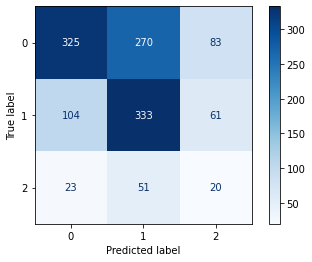

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       678
           1       0.62      0.63      0.63       498
           2       0.18      0.21      0.19        94

    accuracy                           0.64      1270
   macro avg       0.51      0.52      0.51      1270
weighted avg       0.65      0.64      0.65      1270

0.5182452019841116
Kappa Score :
0.36535506566810627


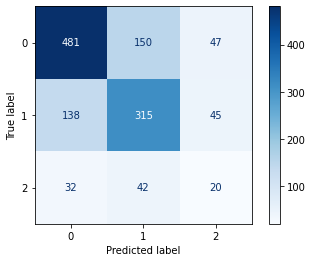

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       678
           1       0.65      0.69      0.67       498
           2       0.19      0.20      0.20        94

    accuracy                           0.67      1270
   macro avg       0.54      0.54      0.54      1270
weighted avg       0.68      0.67      0.67      1270

0.5390265007812586
Kappa Score :
0.4157639346582741


In [ ]:
#pickle.dump(model10, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/BinaryProblem_Data/ColorFeatures_Bagging_model.sav', 'wb'))

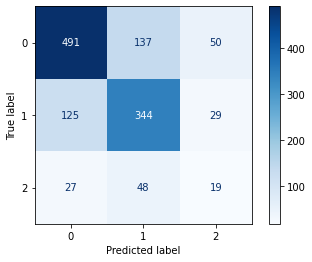

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       678
           1       0.65      0.71      0.68       498
           2       0.26      0.26      0.26        94

    accuracy                           0.69      1270
   macro avg       0.56      0.56      0.56      1270
weighted avg       0.69      0.69      0.69      1270

0.5644337218326642
Kappa Score :
0.43877754445655337


In [ ]:
#pickle.dump(model11, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/BinaryProblem_Data/ColorFeatures_Stacking_model.sav', 'wb'))

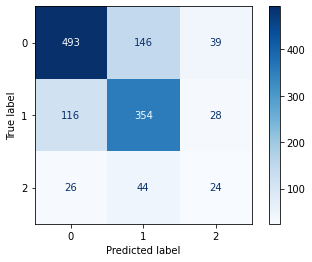

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()